<a href="https://colab.research.google.com/github/gaixen/BCS_recruitment/blob/main/Mission%20Synaptech%3A%20Save%20Dr.%20Z%E2%80%99s%20Mind/demo-solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and setting dependencies

In [116]:
#pip install brian2
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

# Cortical Microcircuit Simulation in Brian2 involving membrane potential dynamics
Simulates a simplified cortical microcircuit with excitatory(make the MP less negative) and inhibitory neurons(make the MP more negative), STDP, and external input.

In [114]:
#Setting simulation units
start_scope()
duration = 500*ms

 **Izhikevich model**

WARNING    The object 'neurongroup_4' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '<ipython-input-92-15292cb3cea4>', line 5, in <cell line: 0>
    neurons = NeuronGroup(N, model=eqs, threshold='v > 30*mV',reset=reset, method='euler') [brian2.core.base.unused_brian_object]
WARNING    The object 'synapses_1' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '<ipython-input-96-d9f77e9eeae9>', line 4, in <cell line: 0>
    input_syn = Synapses(stim, neurons[:Ne], on_pre='v_post += 2*mV') [brian2.core.base.unused_brian_object]
WARNING    The object 'poissongroup' is getting delete

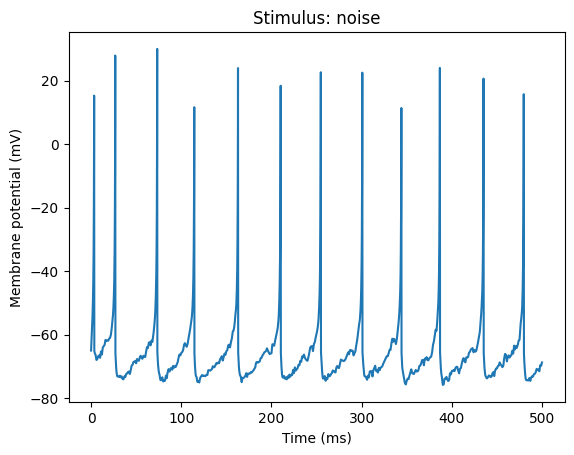

In [115]:
#Izhikevich model
#setting the values of parameters
#all standard values are taken from "Simple Model of Spiking Neurons" by Eugene M. Izhikevich
a,b,c,d = 0.02/ms, 0.2/ms, -65*mV, 8*mV/ms

eqs = '''
dv/dt = (0.04/ms/mV)*v**2 + 5/ms*v + 140*mV/ms - u + I : volt
du/dt = a*(b*v - u) : volt/second
I : volt/second
'''
#after a spike v is set to c and u is increased by an amount of d
reset = '''
v = c
u += d
'''
#in Neurongroup no of neurons is set to 1
neuron = NeuronGroup(1, eqs, threshold='v > 30*mV', reset=reset, method='euler')
neuron.v = -65*mV
neuron.u = b * neuron.v
#set the stimulation type to 'constant', 'pulse', or 'noise'
stim_type = 'noise'
if stim_type == 'constant':
    neuron.I = 10*mV/ms
elif stim_type == 'pulse':
    I_timed = TimedArray([0, 10, 10, 0]*50*mV/ms, dt=1*ms)
    neuron.run_regularly('I = I_timed(t)', dt=1*ms)
elif stim_type == 'noise':
    @network_operation(dt=1*ms)
    def update_input():
        neuron.I = (10 + randn())*mV/ms

mon = StateMonitor(neuron, 'v', record=0)

run(duration)
#plotting the membrane potential dynamics(heartbeat of neuron:))
plot(mon.t/ms, mon.v[0]/mV)
xlabel('Time (ms)')
ylabel('Membrane potential (mV)')
title(f'Stimulus: {stim_type}')
show()

In [ ]:
#Setting simulation units
start_scope()
duration = 500*ms
#Izhikevich model equations and parameters
#'e' stands for excitatory and 'i for inhibitory'
#all standard values are taken from "Simple Model of Spiking Neurons" by Eugene M. Izhikevich
a_e, b_e, c_e, d_e = 0.02/ms, 0.2/ms, -65*mV, 8*mV/ms
a_i, b_i, c_i, d_i = 0.1/ms, 0.2/ms, -65*mV, 2*mV/ms
eqs = '''
dv/dt = (0.04/ms/mV)*v**2 + 5/ms*v + 140*mV/ms - u + I : volt
du/dt = a*(b*v - u) : volt/second
I : volt/second
a : 1/second
b : 1/second
c : volt
d : volt/second
'''


In biological neurons, the Na+ ions enter into the neuron to increase the voltage of the neuron. At a certain point, the floodgates open and Na+ ions come rushing into the neuron.This causes the voltage inside the neuron to shoot right up (spike). But it's this point where the K+ gates open up, and a ton of K+ ions shoot out of the neuron Causing the voltage to drop right down.The voltage in this case is the membrane potential (v). And the K^+ is the membrane recovery variable (u).

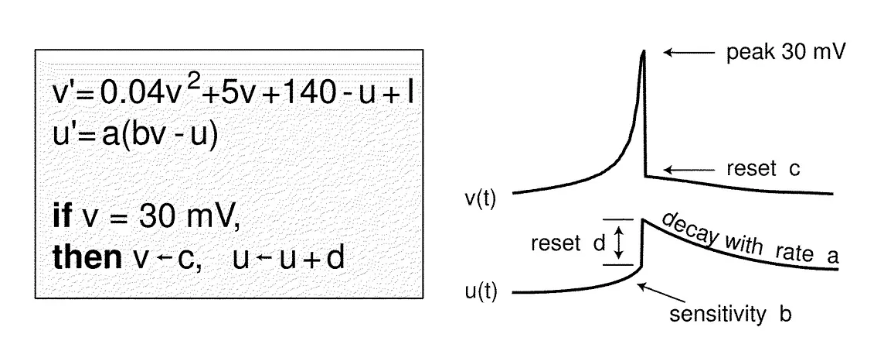

# Create neuron groups**(0-79:excitatory;80-99:inhibitory)**

In [ ]:
N = 100
Ne = int(0.8 * N)
Ni = N - Ne
neurons = NeuronGroup(N, model=eqs, threshold='v > 30*mV',reset=reset, method='euler')
#Initialize global neuron parameters which are independent of e or i
neurons.v = -65*mV
neurons.u = neurons.b * neurons.v
neurons.I = 5*mV/ms
#Assign parameters for inhibitory neurons
neurons.a[:Ne] = a_e
neurons.b[:Ne] = b_e
neurons.c[:Ne] = c_e
neurons.d[:Ne] = d_e
#Assign parameters for inhibitory neurons
neurons.a[Ne:] = a_i
neurons.b[Ne:] = b_i
neurons.c[Ne:] = c_i
neurons.d[Ne:] = d_i

# Formulating the Spike Time Dependent Plasticity(STDP)

 Neurons that fire together, wire together-'Hebbian Learning'. If pre-synaptic neuron fires before the post the synapse is strengthened(LTP) else it's weakened(LTD)

In [ ]:
#defining STDP synapses (excitatory to all)
#'w'is synaptic weight,'A's are learning rates and tau's are decay rate constants
stdp_eqs = '''
w : 1
dApre/dt = -Apre / tau_pre : 1 (event-driven)
dApost/dt = -Apost / tau_post : 1 (event-driven)
'''
#Long term Potentiation
#pre-synaptic neuron fired
#weight updated using Apost
on_pre = '''
v_post += w*mV
Apre += dApre
w = clip(w + Apost, 0, wmax)
'''
#Long Term Depression
#post-synaptic neuron fired
#weight updated using Apre
on_post = '''
Apost += dApost
w = clip(w + Apre, 0, wmax)
'''
#setting the values of parameters
tau_pre = 20*ms
tau_post = 20*ms
dApre = 0.01
dApost = -dApre * 1.05
wmax = 1.0
#now 80% of neurons i.e. the excitatory ones are presynaptic and 100% are taken as postsynaptic
#thus the STDP equations are implemented
syn_ee = Synapses(neurons[:Ne], neurons, model=stdp_eqs, on_pre=on_pre, on_post=on_post)
syn_ee.connect(p=0.1)
#this controls all the excitatory neurons to connect to others with 10% probability
#rand() generates a random number between 0 to 1, thus updating the weight
syn_ee.w = '0.5 + 0.1*rand()'

# **Excitatrory** neuron firing

In [ ]:
#Inhibitory to excitatory synapses
#when inhibitory neuron fires it decreases target neuron potential by 1mV
#inhibitory neurons are presynaptic(20%) and excitatory neurons are postsynaptic(80%)
syn_ie = Synapses(neurons[Ne:], neurons[:Ne], on_pre='v_post -= 1*mV')
syn_ie.connect(p=0.3)

# **Poisson** Group of artificial neurons(~20)

In [ ]:
#external input (Poisson group of 20 neurons) firing at 10Hz frequency.
stim = PoissonGroup(20, rates=10*Hz)
#poisson group neurons as presynaptic and excitatory as postsynaptic
input_syn = Synapses(stim, neurons[:Ne], on_pre='v_post += 2*mV')
#50%connectedness i.e. ~40*20=800 synapses
input_syn.connect(p=0.5)

# **Tracking** the neuron firing

In [ ]:
#spike-monitors track neuron firings
#state monitors track internal parameters
spike_mon = SpikeMonitor(neurons)
volt_mon = StateMonitor(neurons, 'v', record=range(5))

In [ ]:
# Run simulation
run(duration)

# Plotting the results

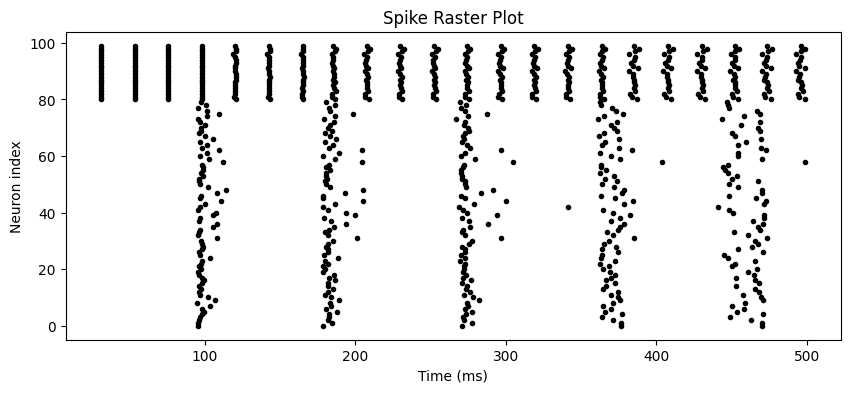

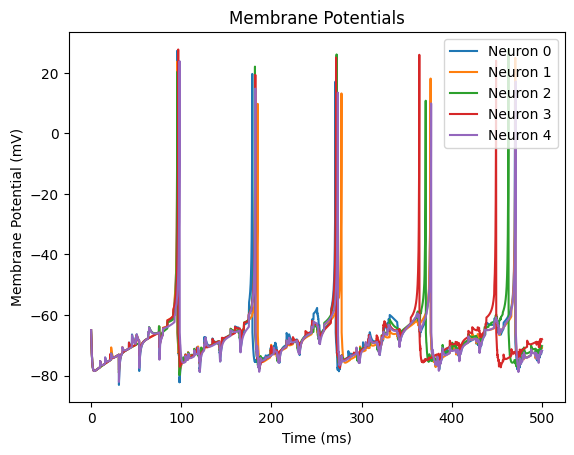

In [ ]:
#plot results
figure(figsize=(10,4))
plot(spike_mon.t/ms, spike_mon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
title('Spike Raster Plot')
show()
#plotting membrane potential dynamics
figure()
for i in range(5):
    plot(volt_mon.t/ms, volt_mon.v[i]/mV, label=f'Neuron {i}')
xlabel('Time (ms)')
ylabel('Membrane Potential (mV)')
legend()
title('Membrane Potentials')
show()